# Análisis de puntuación de comercios

**Autores:**

- José Antonio Nazar Alaez (jose.nazar@cunef.edu)

- Francisco Martínez García (f.martinezgarcia@cunef.edu)

En este trabajo analizaremos los datos sobre unas reseñas realizadas a distintos comercios en los Estados Unidos de América. Estas reseñas tienen una puntuación de 0 a 5. Nuestro objetivo será predecir si una reseña es bunea (mayor o igual a 4) o mala.

Los datos utilizados han sido obtenidos en la página web https://www.yelp.com/dataset/download y consta de 5 archivos json: business, checkin, tip, review y user.

# EDA

En este primer notebook realizaremos un análisis de los datos y crearemos el data frame con las variables deseadas para hacer nuestro modelo.

## Funciones

In [44]:
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0


## Importación de librerías

In [45]:
#Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import json
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

## Carga de datos y creación de data frames

In [46]:
#Read checkin data
with open ('./data/yelp_academic_dataset_checkin.json','r',encoding='utf-8') as f:

    datos=[]
    
    for line in f:
        objeto = json.loads(line)
        
        datos.append(objeto)
        
checkin = pd.DataFrame(datos)
checkin.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [47]:
#Read tip data
with open ('./data/yelp_academic_dataset_tip.json','r',encoding='utf-8') as f:

    datos=[]
    
    for line in f:
        objeto = json.loads(line)
        
        datos.append(objeto)
        
tip = pd.DataFrame(datos)
tip.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [48]:
#Read user data
with open ('./data/yelp_academic_dataset_user.json','r',encoding='utf-8') as f:

    datos=[]
    
    for line in f:
        objeto = json.loads(line)
        
        datos.append(objeto)
        
user = pd.DataFrame(datos)
user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [49]:
#Read business data
with open ('./data/yelp_academic_dataset_business.json','r',encoding='utf-8') as f:

    datos=[]
    
    for line in f:
        objeto = json.loads(line)
        
        datos.append(objeto)
        
business = pd.DataFrame(datos)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [50]:
#Read review data
with open ('./data/yelp_academic_dataset_review.json','r',encoding='utf-8') as f:

    datos=[]
    
    for line in f:
        objeto = json.loads(line)
        
        datos.append(objeto)
        
review = pd.DataFrame(datos)

In [51]:
#Save the df
with open('./models/review.pickle', 'wb') as f:
    pickle.dump(review, f)

In [52]:
#Load the df
with open('./models/review.pickle', 'rb') as f:
    review = pickle.load(f)

De la tabla review eliminaremos las aquellas variables que no nos serán útilies: review_id, 'user_id, text y date. Además quitaremos la columna stars ya que esta se encuentra en en la tabla business.

También agruparemos las reviews por business id para así poder unirla con la tabla business.

In [53]:
#Delete the columns that will not be used
review = review.drop(['review_id', 'user_id', 'text', 'date', 'stars'], axis=1)

In [54]:
#Group reviews by business
review = review.groupby(['business_id']).mean()

In [55]:
#Round the mean to 2 decimals
review = review.apply(lambda x: round(x, 2))
review.head()

,useful,funny,cool
business_id,,,
---kPU91CF4Lq2-WlRu9Lw,0.67,0.04,0.54
--0iUa4sNDFiZFrAdIWhZQ,1.79,0.21,0.29
--30_8IhuyMHbSOcNWd6DQ,0.78,0.22,0.00
--7PUidqRWpRSpXebiyxTg,0.75,0.17,0.00
--7jw19RH9JKXgFohspgQw,1.23,0.00,0.00


Después de analizar los datos obtenidos en cada tabla, consideramos que las únicas tablas útiles para nuestro análisis son business y review. Para ello harenos un merge utilizando como columna en común business id para unirlas. 

Una vez unidas eliminaremos las columnas nombres, horas y business id ya que no nos aportan información útil para nuestros modelos.

In [56]:
#Merge business and review
business = pd.merge(business, review, on='business_id', how='left')
business = business.drop(['hours', 'business_id', 'name'], axis=1)
business.head()

,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,useful,funny,cool
0,"1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",1.29,0.43,0.14
1,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...",1.27,0.40,0.40
2,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...",0.88,0.83,0.50
3,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.51,0.54,1.09
4,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food",0.15,0.00,0.00


In [57]:
#Save the data
with open('./models/business.pickle', 'wb') as f:
    pickle.dump(business, f)

In [58]:
#Load the data
with open('./models/business.pickle', 'rb') as f:
    business = pickle.load(f)

## Null values

A continución analizaremos la cantidad de valores nulos de la nueva tabla business.

In [59]:
#Calculation od the null data
pd_series_null_columns = business.isnull().sum().sort_values(ascending=False)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])  

In [60]:
pd_null_columnas

,nulos_columnas
attributes,13744
categories,103
address,0
city,0
state,0
postal_code,0
latitude,0
longitude,0
stars,0
review_count,0


Existen valores nulos en attributes y categories. Eliminaremos estos valores nulos ya que las categorías pueden ser una variable importante a la hora de predecir la puntuación de las reseñas.

In [61]:
#Drop na to create new column cat2
business = business.dropna(axis=0)
business = business.reset_index(drop=True)

## Correlación

Estudiamos la correlación entre las variables numércias.

In [62]:
#Numeric variables
list_numeric_var = ["stars", "review_count", "useful", "funny", "cool"]

In [63]:
#Calculation of the correlation
corr = business[list_numeric_var].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
23,cool,funny,0.669947
22,cool,useful,0.552619
17,funny,useful,0.519374


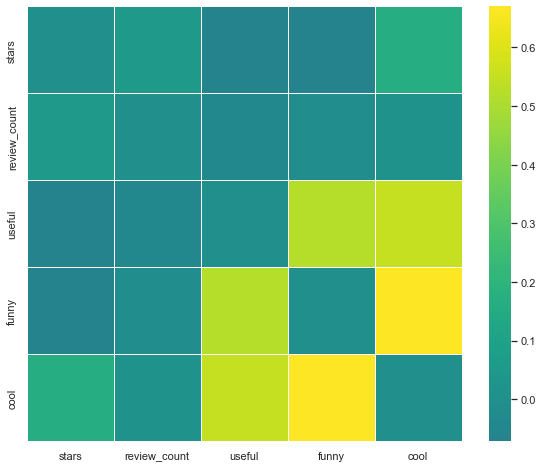

0

In [64]:
#plot the correlation matrix
get_corr_matrix(dataset = business[list_numeric_var], 
                metodo='pearson', size_figure=[10,8])

Se puede apreciar que las variables que más correlación tienen entre sí son 'funny', 'useful' y 'cool'. Aún así la mayor correlación es de tan solo 0.67, por lo tanto no realizaremos modificaciones.

# Mapas


En este apartado del EDA, realizaremos un análisis geográfico de los datos utilizando la columna 'state' y la longitud y latitud. 

### Mapa por estado

Relaizaremos 2 mapas por estado: el primero teniendo en cuenta el número de reviews, y el segundo la puntuación.

In [65]:
#Read the map representation data
geo_data = gpd.read_file('./data/usa-states-census-2014.shp')
#Change the column name STUSPS to state so its the same as our data frame
geo_data = geo_data.rename(columns={'STUSPS': 'state'})

In [66]:
#Group the data by state
business_geo = business.groupby(['state']).agg({'stars': ['mean'], 'review_count': ['sum']})

In [67]:
#Rename the columns
business_geo.columns = ['stars_mean', 'reviews']
business_geo.head()

,stars_mean,reviews
state,,
AB,3.487115,99451
AZ,3.620964,400535
CA,4.010602,332344
CO,4.000000,30
DE,3.391683,65124


In [68]:
#Create a data frame with all the states included
states = geo_data['state'].unique()
states = pd.DataFrame(states)
states.columns=['state']

In [69]:
#Add the missing states to the data frame with 0 values
business_geo = pd.merge(states, business_geo,  on='state', how='outer').fillna(0)
business_geo.head()

,state,stars_mean,reviews
0,CA,4.010602,332344.0
1,DC,0.000000,0.0
2,FL,3.642321,1087557.0
3,GA,0.000000,0.0
4,ID,3.744775,147232.0


<AxesSubplot:>

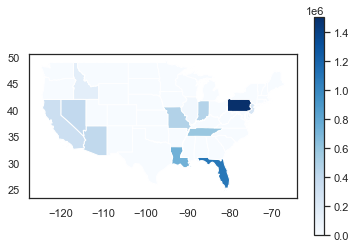

In [70]:
(geo_data
    .dissolve(by='state')
    .merge(business_geo, on='state', how='left')
    .plot('reviews', cmap='Blues', legend=True)
)

Una gran cantidad de reseñas se encuentran en el estado de Pensilvania, teniendo también un color oscura Florida. Se puede observar la falta de datos en muchos de los estados, sobretodo aquellos del centro del país.

<AxesSubplot:>

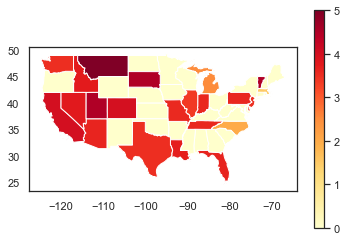

In [71]:
(geo_data
    .dissolve(by='state')
    .merge(business_geo, on='state', how='left')
    .plot('stars_mean', cmap='YlOrRd', legend=True)
)

Las mejores puntuaciones han sido obtenidas en Montana. El resto de estados también tienen colores rojizos, significando buena nota, pero algunos como Michigan, Carolina del Norte o Massachusetts tienen colores más claros, obteniendo una puntuación media inferior al resto de estados.

### Mapa por coordenadas

Con este mapa podremos ver la localización y distribución de los negocios por el territorio de Estados Unidos.

In [72]:
from shapely.geometry import Point, Polygon
geometry = [Point(xy) for xy in zip(business["longitude"], business["latitude"])]

In [73]:
crs = {'init': 'epsg:4326'}

geo_df = gpd.GeoDataFrame(business,
                         crs=crs,
                         geometry=geometry)
geo_df.head()

,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,useful,funny,cool,geometry
0,"1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",1.29,0.43,0.14,POINT (-119.71120 34.42668)
1,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...",1.27,0.40,0.40,POINT (-90.33570 38.55113)
2,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...",0.88,0.83,0.50,POINT (-110.88045 32.22324)
3,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1.51,0.54,1.09,POINT (-75.15556 39.95551)
4,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food",0.15,0.00,0.00,POINT (-75.47166 40.33818)


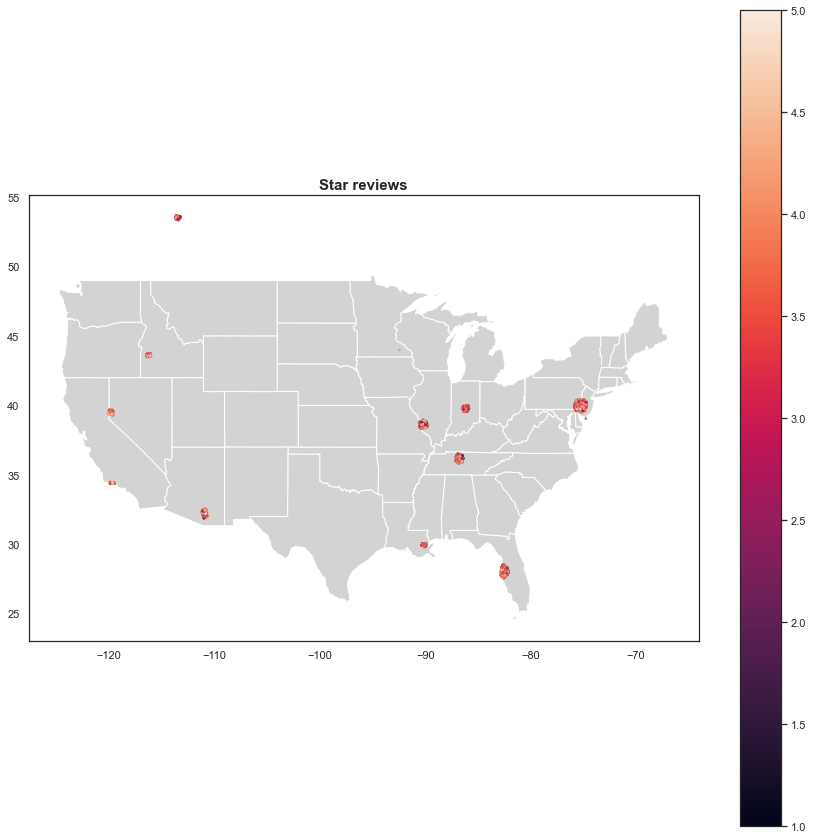

In [74]:
fig,ax = plt.subplots(figsize =(15,15))
geo_data.plot(ax=ax, alpha = 1, color='lightgrey')
geo_df.plot(column='stars',ax=ax,alpha=0.5, legend=True,markersize=3)
plt.title('Star reviews', fontsize=15,fontweight='bold')
plt.show()

Se peude observar en el mapa superior que los negocios están agrupados en regiones o ciudades específicas dentro de su estado, siendo difícil observar 2 distintas aglomeraciones de negocios en un mismo estado.

# Columna category

El data frame de business tiene 2 columnas que procederemos a modificar. Primero la columna category, la cual la utilizaremos para crear otra columna con 10 categorías generales. Estas serán restaurantes, spa y belleza, compras, salud y médica, automotor, servicio y planificación de eventos, arte y entretenimiento, hoteles y viajes, vida activa, y centros de envío.

In [75]:
#With this loop we will analyze and select the general categories
for i in range(0,50):
    print(business['categories'][i])

Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists
Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services
Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores
Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries
Brewpubs, Breweries, Food
Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants
Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories
Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek
Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food
Department Stores, Shopping, Fashion
Vietnamese, Food, Restaurants, Food Trucks
American (Traditional), Restaurants, Diners, Breakfast & Brunch
General Dentistry, Dentists, Health & Medical, Cosmetic Dentists
Food, Delis, Italian, Bakeries, Restaurants
Sushi Bars, Restaurants, Japanese
Automotive, Auto Parts & Supplies, Auto Customization
Vape Shops, Tobacco 

In [23]:
#Create data frame to insert the new column
business_cat = pd.DataFrame()

for i in range(0,len(business)):
    if 'Restaurants' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Restaurants'
    if 'Beauty & Spas' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Beauty & Spas'
    if 'Shopping' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Shopping'
    if 'Health & Medical' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Health & Medical'
    if 'Automotive' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Automotive'
    if 'Active Life' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Active Life'
    if 'Hotels & Travel' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Hotels & Travel'
    if 'Arts & Entertainment' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Arts & Entertainment'
    if 'Event Planning & Services' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Event Planning & Services'
    if 'Shipping Centers' in business['categories'][i]:
        business_cat = business_cat.append(business.loc[i])
        business_cat['categories'].loc[i] = 'Shipping Centers'

In [24]:
#Save the df
with open('./models/business_cat.pickle', 'wb') as f:
    pickle.dump(business_cat, f)

In [76]:
#Load the df
with open('./models/business_cat.pickle', 'rb') as f:
    business_cat = pickle.load(f)

Text(0.5, 1.0, 'Número de tiendas por categoría')

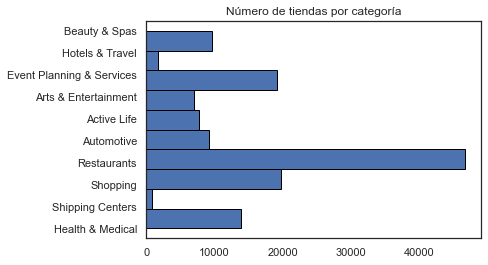

In [77]:
plt.hist(business_cat['categories'], orientation='horizontal', edgecolor='black')
plt.title('Número de tiendas por categoría')

En la gráfica superior se puede apreciar que la categoría más reseñas con mucha diferencia es restaurantes, seguidos por las compras y los eventos. Por otro lado, se puede observar que los hoteles y los centros de envío son los que menor número de datos tenemos con una diferencia notable sobre la siguiente categoría.

A continuación utilizaremos el One Hot Encode para hacer una codificación de estas variables categóricas.

# Codificación de variables categóricas

### Separación de variable objetivo

Como ha sido mencionado anteriormente, en este trabajo haremos un modelo predictivo sobre las puntuaciones obtenidas en las reseñas. Serán positvas aquellas con 4 estrellas o superior, y negativas aquellas con menos de 4 estrellas. Primero crearemos la columna objetivo

In [78]:
#Convert stars column
business_cat = business_cat.assign(punctuation=business_cat.stars.apply(lambda x: 1 if x >=4 else 0)) 
business_cat.head()

,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,useful,funny,cool,punctuation
0,"1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},Health & Medical,1.29,0.43,0.14,1
1,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},Shipping Centers,1.27,0.40,0.40,0
2,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",Shopping,0.88,0.83,0.50,0
3,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,1.51,0.54,1.09,1
5,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...",Restaurants,0.00,0.00,0.00,0


Ahora separaremos la nueva variable objetivo

In [79]:
#Select all the columns except the target variable
X_punctuation = business_cat.drop('punctuation',axis=1)

#Select the target variable
y_punctuation = business_cat['punctuation']

### Codificación

A continuación codificaremos la variable 'categories' utilizando One Hot Encode y pondremos el nombre original de cada una en su respectiva columna 

In [80]:
#convertion of categorical variables with one hot encoder
ohe = ce.OneHotEncoder(cols=['categories'])
model = ohe.fit(X_punctuation, y_punctuation)

In [81]:
X_punctuation_t = model.transform(X_punctuation, y_punctuation)

In [82]:
# ahora grafo por las categorias
X_punctuation_t.rename(columns={
    'categories_1': 'Health & Medical',
    'categories_2': 'Shipping Centers',
    'categories_3': 'Shopping',
    'categories_4': 'Restaurants',
    'categories_5': 'Automotive',
    'categories_6': 'Active Life',
    'categories_7': 'Arts & Entertainment',
    'categories_8': 'Event Planning & Services',
    'categories_9': 'Hotels & Travel',
    'categories_10': 'Beauty & Spas'
}, inplace=True)

# Selección final de datos para la tabla utilizada en la predicción

Después de realizar el análisis, nos quedaremos solo con las variables útiles para realizar nuestros modelos de predicción y guardaremos los datos en un archivo parquet.

In [83]:
X_punctuation_t = X_punctuation_t.drop(['state','address', 'city', 'postal_code', 'latitude', 'longitude', 'attributes'], axis=1)

### Creación de train y test

In [84]:
#20% of the data will be used as test data. Due to imbalance, use of stratify
X_train, X_test, y_train, y_test = train_test_split(X_punctuation_t, 
                                                    y_punctuation, 
                                                    stratify=y_punctuation, 
                                                    test_size=0.2, 
                                                    random_state=12345)

In [85]:
#Unimos las tablas x, y para su extracción
X_test['punctuation'] = y_test
X_train['punctuation'] = y_train

# Descarga de datos

In [86]:
#Create new CSV documetns with the training and test data separated
X_train.to_parquet("./data/training_grapho.parquet")
X_test.to_parquet("./data/test_data.parquet")